In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
import os

#from skimage import color, exposure
# for hog feature detection
from skimage.feature import hog

# for colour feature detection
from sklearn.preprocessing import StandardScaler

# to split training data
from sklearn.model_selection import train_test_split

# for Linear SVC
from sklearn.svm import LinearSVC

# for grid search method to find optimum parameters
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

import matplotlib.gridspec as gridspec

from scipy.ndimage.measurements import label




In [2]:
# specify location to load training data from
images = glob.glob('./data/*/*/*.png')
# create 2 arrays to store data
cars = []
notcars = []

# images are divided up into vehicles and non-vehicles
for image in images:
    # if images location has non-vehicles then append to notcars array
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)



### Data Exploration

Number of samples of Vehicles: 8792
Number of samples of Non-Vehicles: 8605


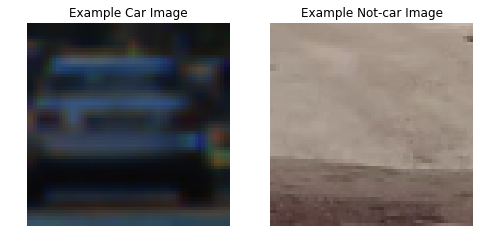

In [3]:
# read in a random image from each dataset
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images - convert to 8 bit images
#car_image = (mpimg.imread(cars[car_ind])*255).astype('uint8')
car_image = mpimg.imread(cars[car_ind])

#notcar_image = (mpimg.imread(notcars[notcar_ind])*255).astype('uint8')
notcar_image = mpimg.imread(notcars[notcar_ind])


# message to show number of samples of each type of image
print ("Number of samples of Vehicles: {0}\nNumber of samples of Non-Vehicles: {1}".format(len(cars), len(notcars)))


# plot example of each image
fig = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.axis('Off')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.axis('Off')

# fig save for report - and minimise amout of white space added to saved image
plt.savefig('./output_images/classes_example.png', bbox_inches='tight')
plt.show()

## Image Processing Functions

### Spatial binning - *scale down resolution of image*

In [4]:
# function to scale down full resolution image
# resize from image size (64 x 64) to new_size(32 x 32)
def bin_spatial(image, size=(32,32)):
    # Use cv2.resize() to resize and .ravel() to convert to vector
    features = cv2.resize(image, size).ravel()
    # Return the feature vector
    return features

Original Car Image size: (64, 64, 3)  Data type: float32  Features: 12288
Binned Car Image size:   (32, 32, 3)  Data type: float32  Features: 3072


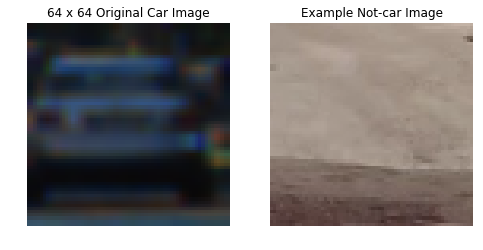

In [5]:
# visualise the cv2.resize
binned_image = cv2.resize(car_image, (32, 32))
# test binning function - default resize is 32 x 32 so not specified
binned_features = bin_spatial(car_image)

# compare data size and data type before and after processing
print("Original Car Image size: {0}  Data type: {1}  Features: {2}".format(car_image.shape, car_image.dtype, (len(car_image.ravel()))))
print("Binned Car Image size:   {0}  Data type: {1}  Features: {2}".format(binned_image.shape, binned_image.dtype,(len(binned_features))))


# plot example of each image
fig = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(car_image)
plt.title('64 x 64 Original Car Image')
plt.axis('Off')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.axis('Off')

# fig save for report - and minimise amout of white space added to saved image
plt.savefig('./output_images/binning_example.png', bbox_inches='tight')
plt.show()




### Colour Histogram - *extract distribution of colours over channels to provide shape information*

In [6]:
# Define a function to compute color histogram features  
# bins range: (0,256) = 8bit image, (0.0,1.0) = 24bit png
def color_hist(img, nbins=32, bins_range=(0,256), vis=True):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # if want to plot/visualise historgram
    if vis == True:
        # Generating bin centers
        bin_edges = channel1_hist[1]
        #width = 0.90 * (bin_edges[1] - bin_edges[0])
        bins_centre = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return channel1_hist, channel2_hist, channel3_hist, bins_centre, hist_features
    
    else:
        # return histogram features
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        
        return hist_features

In [7]:
def colour_space_explore(img, obj):
    # explore each colour space to see the histogram and channel image
    colour_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

    for cspace in colour_spaces:
        if cspace != 'RGB':
            if cspace == 'HSV':
                sample_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                sample_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                sample_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                sample_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                sample_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: sample_image = np.copy(img)

        # calculate colour histogram - png bins range 0.0, 1.0
        ch1, ch2, ch3, bins_centre, features = color_hist(sample_image, nbins=32, bins_range=(0.0, 1.0), vis=True)
       
        # compare data size and data type before and after processing
        print("Original Image size:     {0}  Data type: {1}  Features: {2}".format(img.shape, img.dtype, (len(img.ravel()))))
        print("Colour Space Image size: {0}  Data type: {1}  Features: {2}".format(sample_image.shape, sample_image.dtype,(len(features))))

        # plot example of each image
        fig = plt.figure(figsize=(20,3))
        plt.subplot(161)
        plt.bar(bins_centre, ch1[0], align='center', width=0.02)
        plt.title('ch1: ' + cspace )
        plt.subplot(162)
        plt.bar(bins_centre, ch2[0], align='center', width=0.02)
        plt.title('ch2: '+ cspace)
        plt.subplot(163)
        plt.bar(bins_centre, ch3[0], align='center', width=0.02)
        plt.title('ch3: '+ cspace)
        plt.subplot(164)
        plt.imshow((sample_image[:,:,0]), cmap='gray')
        plt.title(obj + ' ch1: '+ cspace)
        plt.axis('Off')
        plt.subplot(165)
        plt.imshow((sample_image[:,:,1]), cmap='gray')
        plt.title(obj + ' ch2: '+ cspace)
        plt.axis('Off')
        plt.subplot(166)
        plt.imshow((sample_image[:,:,2]), cmap='gray')
        plt.title(obj + ' ch3: '+ cspace)
        plt.axis('Off')

        # fig save for report - and minimise amout of white space added to saved image
        plt.savefig('./output_images/colour_space_'+ cspace + '_'+ obj + '.png', bbox_inches='tight')

        plt.show()

    plt.show()




Original Image size:     (64, 64, 3)  Data type: float32  Features: 12288
Colour Space Image size: (64, 64, 3)  Data type: float32  Features: 96


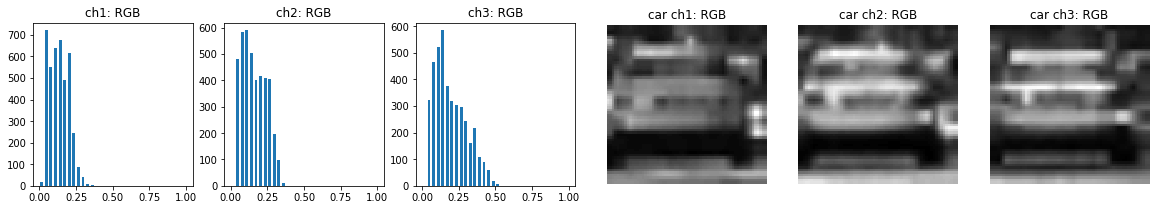

Original Image size:     (64, 64, 3)  Data type: float32  Features: 12288
Colour Space Image size: (64, 64, 3)  Data type: float32  Features: 96


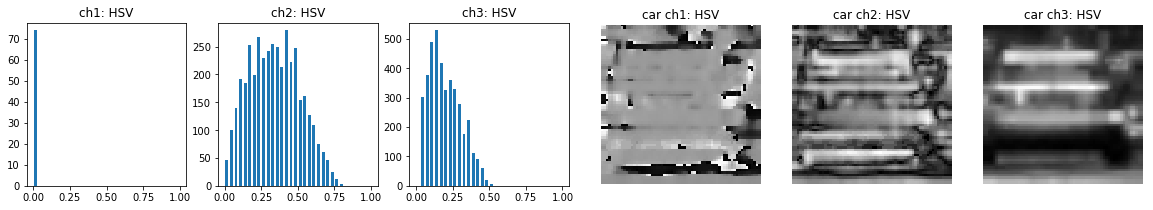

Original Image size:     (64, 64, 3)  Data type: float32  Features: 12288
Colour Space Image size: (64, 64, 3)  Data type: float32  Features: 96


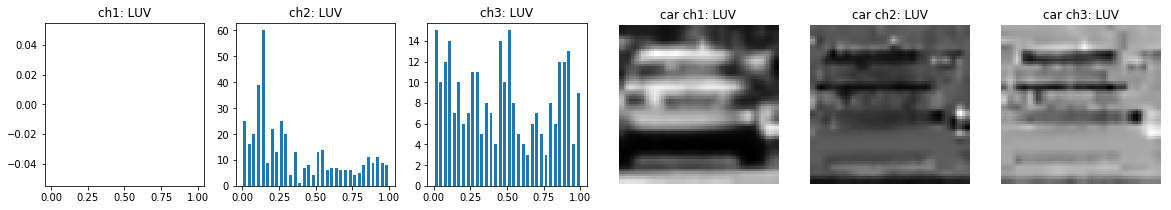

Original Image size:     (64, 64, 3)  Data type: float32  Features: 12288
Colour Space Image size: (64, 64, 3)  Data type: float32  Features: 96


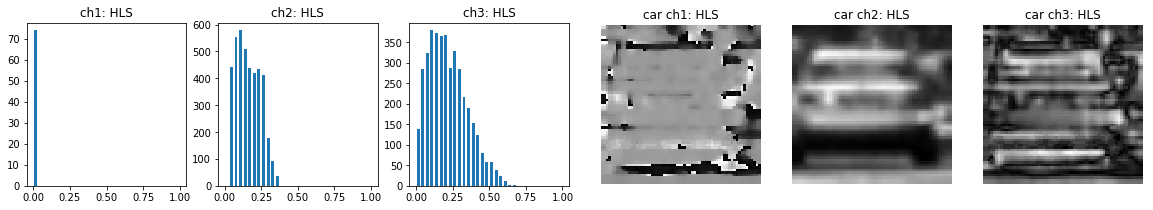

Original Image size:     (64, 64, 3)  Data type: float32  Features: 12288
Colour Space Image size: (64, 64, 3)  Data type: float32  Features: 96


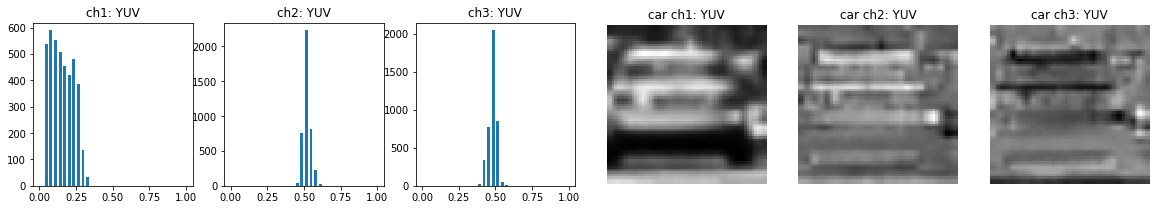

Original Image size:     (64, 64, 3)  Data type: float32  Features: 12288
Colour Space Image size: (64, 64, 3)  Data type: float32  Features: 96


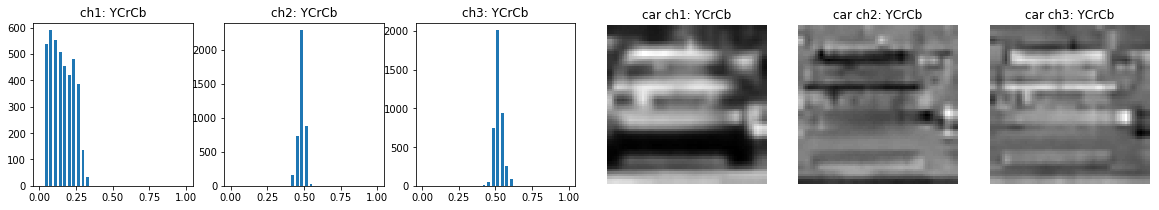

Original Image size:     (64, 64, 3)  Data type: float32  Features: 12288
Colour Space Image size: (64, 64, 3)  Data type: float32  Features: 96


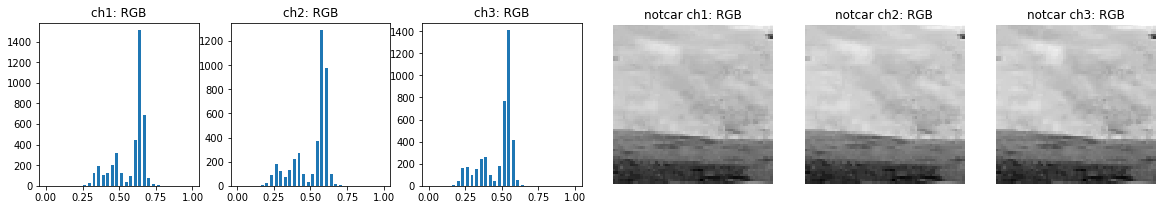

Original Image size:     (64, 64, 3)  Data type: float32  Features: 12288
Colour Space Image size: (64, 64, 3)  Data type: float32  Features: 96


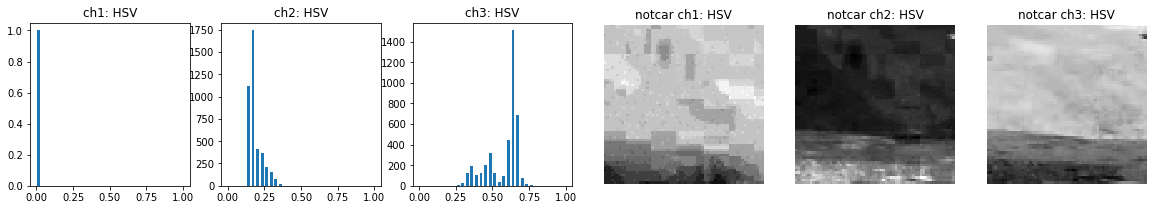

Original Image size:     (64, 64, 3)  Data type: float32  Features: 12288
Colour Space Image size: (64, 64, 3)  Data type: float32  Features: 96


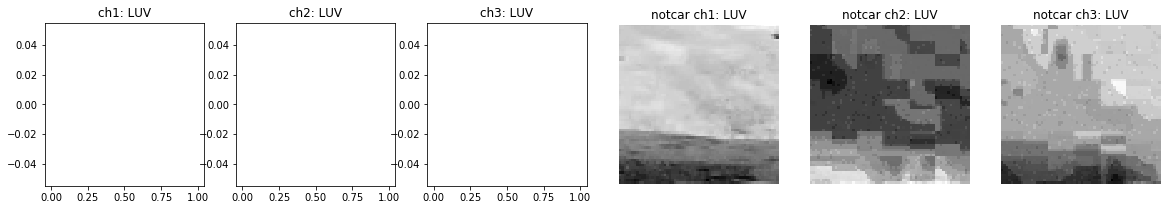

Original Image size:     (64, 64, 3)  Data type: float32  Features: 12288
Colour Space Image size: (64, 64, 3)  Data type: float32  Features: 96


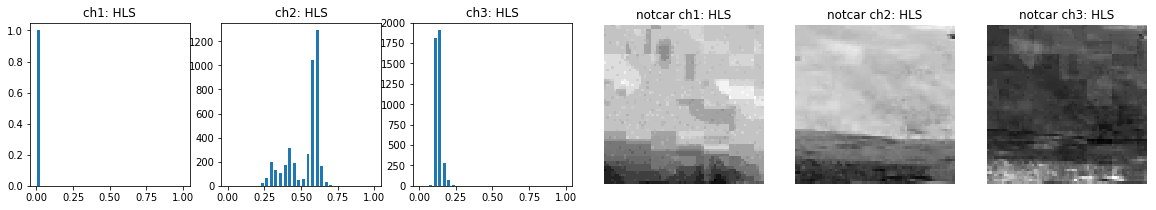

Original Image size:     (64, 64, 3)  Data type: float32  Features: 12288
Colour Space Image size: (64, 64, 3)  Data type: float32  Features: 96


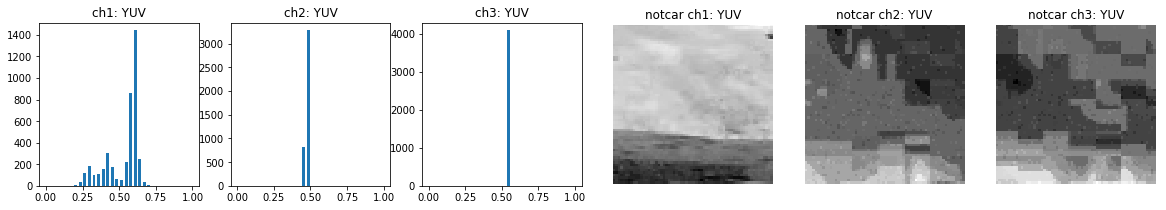

Original Image size:     (64, 64, 3)  Data type: float32  Features: 12288
Colour Space Image size: (64, 64, 3)  Data type: float32  Features: 96


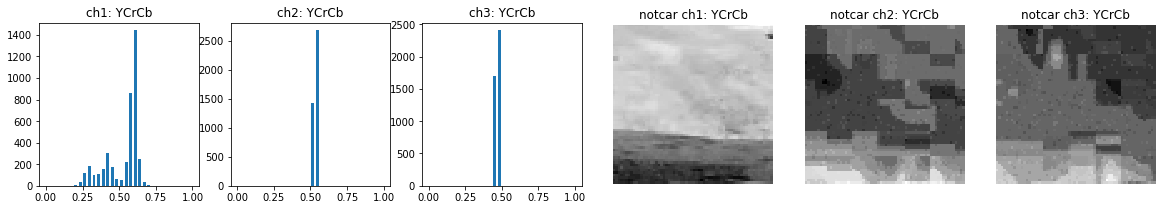

In [8]:
# show colour pace exploration for cars and not cars:
colour_space_explore(car_image, "car")
colour_space_explore(notcar_image, "notcar")

In [9]:
test_colour_space_features  = color_hist(car_image, nbins=32, bins_range=(0.0, 1.0), vis=False)
print("Number of colour space features: {}".format(len(test_colour_space_features)))


Number of colour space features: 96


### Hog Features - *histogram of orientated gradients to get shape inormation in the image*

In [10]:
# Function to return HOG features and visualization
# (if feature_vector = False, then returned as Matrix)
# (if feature_vector = True, then returned as flattened vector)
# Image data returned (if vis = True)   

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    
    # execute hog function - pass in:
    # orientation: number of bins - typical 6 to 12
    # pixels per cell - pixel x,y for cell size
    # cells per block - set number of cells to be normalised as one block
    # transform_sqrt - can help reduce shadow/illumination, but will error if negative values in image
    # image visualisation is set if passed in value of vis = 'True'
    # if feature_vector = 'True', then returns features as 1D vector - same as running features.ravel()
    
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [11]:
def hog_prepare(img, cspace):
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            sample_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            sample_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            sample_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            sample_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            sample_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        sample_image = np.copy(img)
        
    return sample_image

In [12]:
# Call Hog function with vis=True to see image output

#car_image_YCrCb = hog_prepare(car_image, "YCrCb")
#notcar_image_YCrCb = hog_prepare(notcar_image, "YCrCb")

def hog_visualise(img, obj, cspace, name):
    plot_img_all = []
    # pass 1 channel to hog at a time
    for i in range(0,3):
        hog_features, hog_image = get_hog_features(img[:,:,i], orient= 9, pix_per_cell= 8, cell_per_block= 2, vis=True)
        plot_img_all.append(img[:,:,i])
        plot_img_all.append(hog_image)

    fig = plt.figure(figsize=(20,5))

    # variable to keeep track of channel
    ch = 0
    for i in range(len(plot_img_all)):

        plt.subplot(1,6,i+1)
        plt.imshow(plot_img_all[i], cmap = 'gray')
        if i%2 == 0:
            # increment channel
            ch = ch+1
            plt.title(obj + " Image {0} Ch{1}".format(str((cspace)),str((ch)) ))

        else:
            plt.title(obj + " Image Hog Ch{0}".format(str((ch))))
    
    # fig save for report - and minimise amout of white space added to saved image
    plt.savefig('./output_images/hog_'+ name +'.png', bbox_inches='tight')
    plt.show()

In [13]:
def hog_explore(img, obj, cspace, name):
    # convert image to requested colour space
    colourspace_image = hog_prepare(img, cspace)
    
    hog_visualise(colourspace_image, obj, cspace, name)
    
    

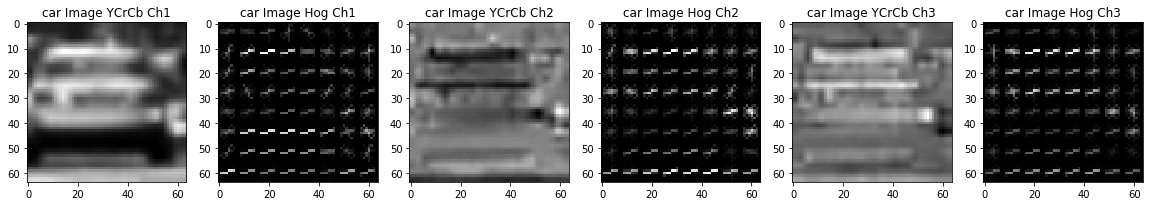

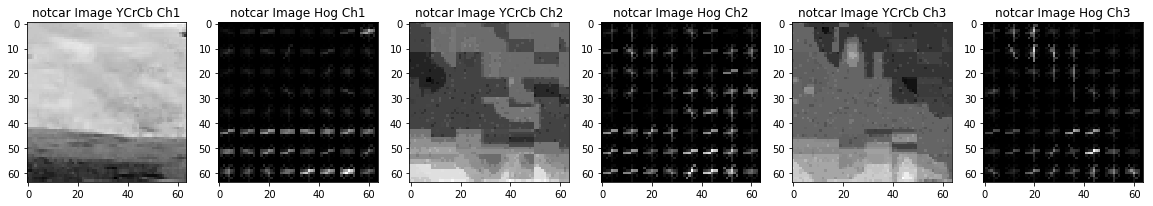

In [14]:
# show hog exploration for cars and not cars:
hog_explore(car_image, "car", "YCrCb", "car_image") #"YCrCb"
hog_explore(notcar_image, "notcar", "YCrCb", "notcar_image") #"YCrCb"

In [15]:
# check number of Hog Features
test_hog_features = get_hog_features(car_image[:,:,0], orient= 9, pix_per_cell= 8, cell_per_block= 2, vis=False)
print("Number of Hog features: {}".format(len(test_hog_features)))

Number of Hog features: 1764


### Extract Features - *Take all the extracted features and concatenate them into a feature vector*

In [16]:
def extract_detail(prepared_image, spatial_size=(32, 32), hist_bins=32, orient=9,pix_per_cell=8, 
             cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True, bins_range=(0, 256)):
    features = []
    
    if spatial_feat == True:
        spatial_features = bin_spatial(prepared_image, size=spatial_size)


    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(prepared_image, nbins=hist_bins, bins_range=bins_range, vis=False)

                   
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(prepared_image.shape[2]):
                hog_features.append(get_hog_features(prepared_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(prepared_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Append the new feature vector to the features list
    features = np.concatenate((spatial_features, hist_features, hog_features))
    
    return features
            

In [17]:

# function to convert image to specified colour space
def extract_prepare(image, color_space):
    
    if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image) 
    
    return(feature_image)


    

In [18]:
def get_params():
    # array to store all parameters
    parameter_set = []
    
    # setup feature parameters
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 8  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    bins_range = (0.0, 1.0) # Colour space range 0,256 8bit, 0.0,1.0 png
    
    # add parameters to paramter_set array
    parameter_set.append(color_space)
    parameter_set.append(orient)
    parameter_set.append(pix_per_cell)
    parameter_set.append(cell_per_block)
    parameter_set.append(hog_channel)
    parameter_set.append(spatial_size)
    parameter_set.append(hist_bins)
    parameter_set.append(spatial_feat)
    parameter_set.append(hist_feat)
    parameter_set.append(hog_feat)
    parameter_set.append(bins_range)
    
    return parameter_set
    

In [19]:
def get_features(image):
    
    # load parameters
    params = get_params()
    
    # setup feature parameters
    color_space = params[0] #'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = params[1] #9  # HOG orientations
    pix_per_cell = params[2] #8 # HOG pixels per cell
    cell_per_block = params[3] #2 # HOG cells per block
    hog_channel = params[4] #0 # Can be 0, 1, 2, or "ALL"
    spatial_size = params[5] #(32, 32) # Spatial binning dimensions
    hist_bins = params[6] #32    # Number of histogram bins
    spatial_feat = params[7] #True # Spatial features on or off
    hist_feat = params[8] #True # Histogram features on or off
    hog_feat = params[9] #True # HOG features on or off
    bins_range = params[10] #(0.0, 1.0) # Colour space range 0,256 8bit, 0.0,1.0 png
    
    
    # prepare the image to correct colour psace
    prepared_image = extract_prepare(image, color_space)
    # get features from colour space image
    features = extract_detail(prepared_image, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient
                              ,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                              spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, bins_range=bins_range)
    
    return features

In [20]:
# check total number of Features
test_features = get_features(car_image)
print("Total Number of features: {0}".format(len(test_features)))

Total Number of features: 5568


## Build Classifier

### Load learning data and extract features for cars and notcars

In [21]:
def extract_feature_set(img_set):
    
    features = []
    for image_path in img_set:
        actual_image = mpimg.imread(image_path)
        extracted_features = get_features(actual_image)
        
        features.append(extracted_features)
    
    return features
        
        

In [22]:
# specify sample size for some test data - low number to reduce time
sample_size = 50
# extract features for test
test_car_features = extract_feature_set(cars[0:sample_size])
test_notcar_features = extract_feature_set(notcars[0:sample_size])

print("Total Number of features for each dataset:\nCars: {0}  notCars: {1}".format(len(test_car_features),len(test_notcar_features)))



Total Number of features for each dataset:
Cars: 50  notCars: 50


In [23]:
print("Shape of features set: ", np.vstack((test_car_features, test_notcar_features)).shape)

Shape of features set:  (100, 5568)


### Extract features; Prepare and split data

In [24]:
# function to take in data sets and split into data to be fed for training
def data_preparation(cars_img_set, not_cars_img_set):
    
    # extract features from image sets
    car_features = extract_feature_set(cars_img_set)
    notcar_features = extract_feature_set(not_cars_img_set)
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # create labels vector to match feature vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
    raw = X_train
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X - training set and test set
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    # return the preapred data
    return X_train, y_train, X_test, y_test, X_scaler, raw


In [25]:
# using sample size specified earlier 
# create sample data to investigate feature normalisation

test_cars_data_set = cars[0:sample_size]
test_notcars_data_set = notcars[0:sample_size]

X_train, y_train, X_test, y_test, X_scaler, raw = data_preparation(test_cars_data_set,test_notcars_data_set)


Feature Vector Length:  5568


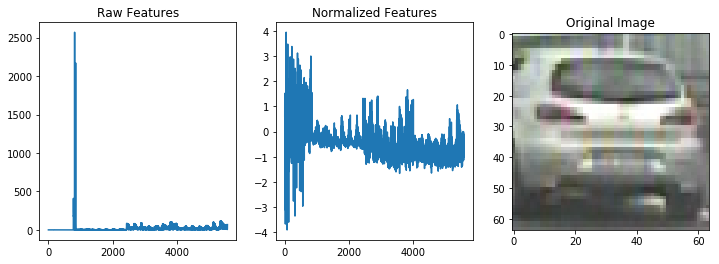

In [26]:
# select data id to visualise (0 to sample_size)
test_sample_number = 21

print("Feature Vector Length: ",len(X_train[test_sample_number]))

# read in image
test_image = mpimg.imread(test_cars_data_set[test_sample_number])

# plot visalisations
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(raw[test_sample_number])
plt.title('Raw Features')
plt.subplot(132)
plt.plot(X_train[test_sample_number])
plt.title('Normalized Features')
plt.subplot(133)
plt.imshow(test_image)
plt.title('Original Image')

# fig save for report - and minimise amout of white space added to saved image
plt.savefig('./output_images/feature_extraction.png', bbox_inches='tight')

plt.show()



### Train and Validate Classifier

In [27]:
def linear_SVC_Classify(cars_dataset, notcars_dataset):
    
    # prepare data sets for training and test
    X_train, y_train, X_test, y_test, X_scaler, raw = data_preparation(cars_dataset,notcars_dataset)
    
    # create a classifier
    svc = LinearSVC()
    
    # log the training start time of the SVC
    t1 = time.time()
    
    svc.fit(X_train, y_train)
    
    # log the training finish time of the SVC
    t2= time.time()
    
    print(round(t2 - t1, 2), " Seconds to train SVC.")
    
    #Check Score of SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    # test prediction of model
    t1 = time.time()
    # number of samples to predict
    n_predict = 10

    print('Trained SVC model predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels:        ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2 - t1, 5), 'Seconds to predict:', n_predict,'labels with SVC')
    
    # get the model parameters used for this model training
    model_parameters = get_params()
    
    # Save model & parmaters into a pickle file 
    svc_pickle = {}
    svc_pickle["svc"] = svc
    svc_pickle["X_scaler"] = X_scaler
    svc_pickle["model_parameters"] = model_parameters
    
    # save to pickle file
    pickle.dump(svc_pickle, open("svc_pickle.p", "wb" ))

    # return test data to validate
    return X_test, y_test
    

### Train model & test saved model

In [28]:
# build and save the SVC model
#test_cars_data_set = cars[0:sample_size]
#test_notcars_data_set = notcars[0:sample_size]
X_test, y_test = linear_SVC_Classify(cars, notcars)


11.82  Seconds to train SVC.
Test Accuracy of SVC =  0.9856
Trained SVC model predicts:  [1. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
For these 10 labels:         [0. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
0.00085 Seconds to predict: 10 labels with SVC


In [29]:
# load the trained model from pickled file
dist_pickle = pickle.load( open("./svc_pickle.p", "rb" ) )

# get the attributes of svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
model_parameters = dist_pickle["model_parameters"]

# setup feature parameters
color_space = model_parameters[0] #'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = model_parameters[1] #9  # HOG orientations
pix_per_cell = model_parameters[2] #8 # HOG pixels per cell
cell_per_block = model_parameters[3] #2 # HOG cells per block
hog_channel = model_parameters[4] #0 # Can be 0, 1, 2, or "ALL"
spatial_size = model_parameters[5] #(32, 32) # Spatial binning dimensions
hist_bins = model_parameters[6] #32    # Number of histogram bins
spatial_feat = model_parameters[7] #True # Spatial features on or off
hist_feat = model_parameters[8] #True # Histogram features on or off
hog_feat = model_parameters[9] #True # HOG features on or off
bins_range = model_parameters[10] #(0.0, 1.0) # Colour space range 0,256 8bit, 0.0,1.0 png

### Vehicle Detection - *use classifier to search images for cars*

In [30]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [31]:
# function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)

# set parameters for sliding window search - only used if slide_window function is used
x_start_stop = [512, 1280]
y_start_stop = [356, 624] 
xy_window = (64, 64) 
xy_overlap=(0.85, 0.5)


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [32]:
# function to define areas in image to search for vehicles

def multi_windows(image):
    
    # specify small windows size and positions
    small_car_windows = slide_window(image, x_start_stop=[576, image.shape[1]], y_start_stop=[410, 480], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.0)) 
    
    # specify medium windows size and positions
    medium_car_windows = slide_window(image, x_start_stop=[600, image.shape[1]], y_start_stop=[422, 530], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.0)) 
    
    # specify large windows size and positions
    large_car_windows = slide_window(image, x_start_stop=[660, image.shape[1]], y_start_stop=[440, 600], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.0 )) 
    
    # specify largest windows size and positions
    super_large_car_windows = slide_window(image, x_start_stop=[800, image.shape[1]], y_start_stop=[470, 665], 
                    xy_window=(192, 192), xy_overlap=(0.5, 0.0 )) 
    
    # build one array of different size windows
    all_windows = []
    all_windows.extend(small_car_windows)
    all_windows.extend(medium_car_windows)
    all_windows.extend(large_car_windows)
    all_windows.extend(super_large_car_windows)
    
    # return complete array of all windows where vehicle search should be carried out
    return all_windows
    

### Visualise sliding window search area

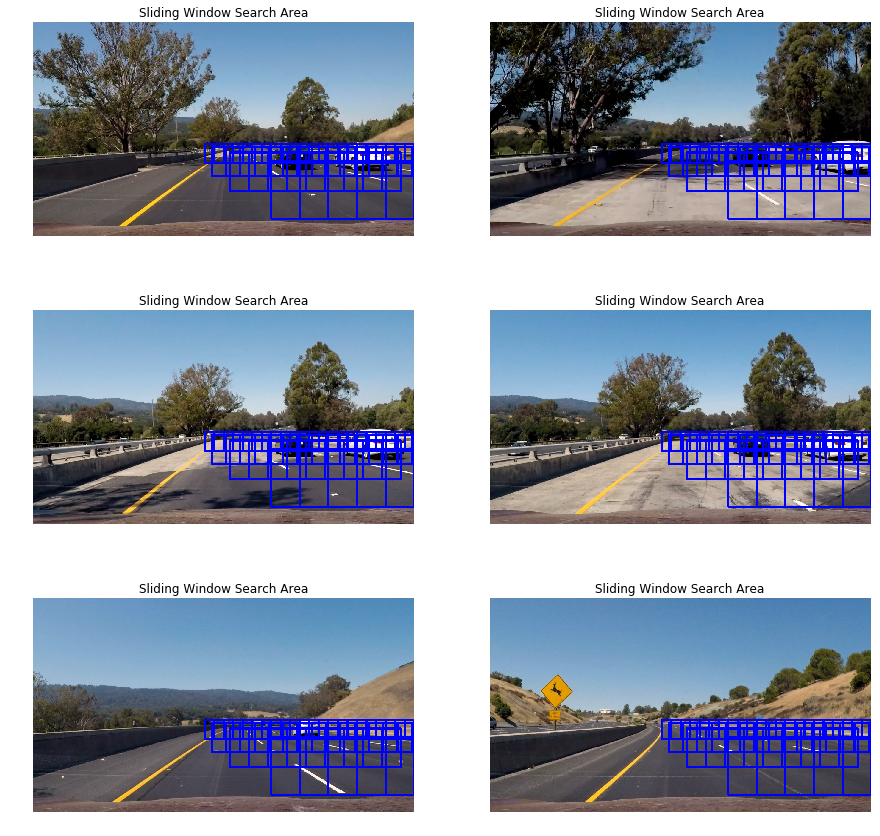

In [33]:
# Make a list of test images
images = glob.glob('./test_images/*.jpg')

# counter for image file naming
i = 0

#create the figure
fig = plt.figure(figsize=(15,15))

# plot each image contained in folder location
for image in images:
    # read in test image
    test_image = mpimg.imread(image)
        
    window_boxes = multi_windows(test_image)
    
    output_image = draw_boxes(test_image, window_boxes)
        
    ax1 = plt.subplot(3, 2, i+1)
    plt.imshow(output_image)
    plt.axis('off')
    plt.title('Sliding Window Search Area')
    
    i = i+1
    
# fig save for report - and minimse amout of white space added to saved image
plt.savefig('./output_images/window_search_area.png', bbox_inches='tight')

plt.show()

In [34]:

# function to detect vehcile positions in image using sliding window search and trained model
def search_for_cars(image, window_boxes, svc, scaler):
 
    # array to hold window boxes where a vehicle was detected
    hot_windows = []
    
    # loop through all window boxes and perfrom image classification
    for box in window_boxes: 
        
        # Extract image box from original image and resize to 64 x 64 to match size of images used to train classifier
        image_box = cv2.resize(image[box[0][1]:box[1][1], box[0][0]:box[1][0]], (64, 64))      
        
        # Extract features from current image
        features = get_features(image_box)
        
        # Scale extracted features to be fed to the classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # classifier prediction of 
        prediction = svc.predict(test_features)
        # If positive prediction
        if prediction == 1:
            # add window to list of hot windows - windows that are classed as containing car image
            hot_windows.append(box)
    
    # return list of windows with vehicle detected 
    return hot_windows

### Visualise Vehicle detections

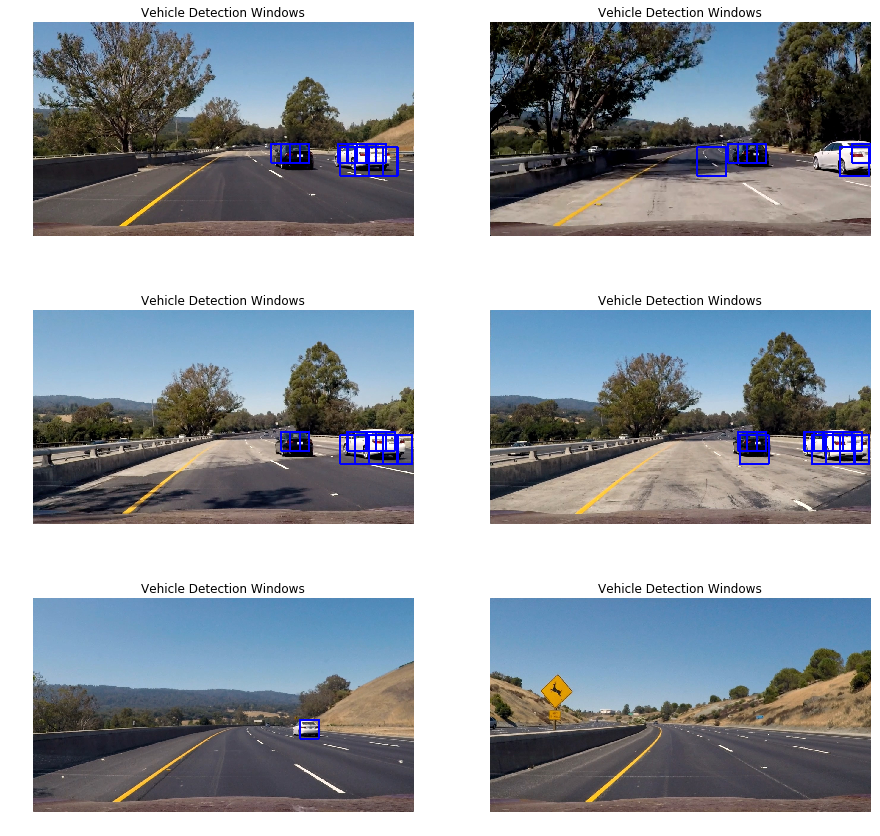

In [35]:
# Make a list of test images
images = glob.glob('./test_images/*.jpg')

# counter for image file naming
i = 0

#create the figure
fig = plt.figure(figsize=(15,15))

# plot each image contained in folder location
for image in images:
    # read in test image
    test_image = mpimg.imread(image)
    
    # required if search image is jpeg and training data was png
    search_image = test_image.astype(np.float32)/255
        
    window_boxes = multi_windows(search_image)
    
    # Find hot Windows
    hot_windows = search_for_cars(search_image, window_boxes, svc, X_scaler)
    
    output_image = draw_boxes(test_image, hot_windows)
        
    ax1 = plt.subplot(3, 2, i+1)
    plt.imshow(output_image)
    plt.axis('off')
    plt.title('Vehicle Detection Windows')
    
    i = i+1
    
# fig save for report - and minimse amout of white space added to saved image
plt.savefig('./output_images/hot_windows_output.png', bbox_inches='tight')

plt.show()

### Heatmap - *create a single box to represent multi-windows detecting vehicle*

In [36]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [37]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [38]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [39]:
# Function to generate heatmap from detections and draw boxes from heatmap

def heatmap_window(img, svc, X_scaler):
    
    # required if search image is jpeg and training data was png
    search_image = img.astype(np.float32)/255
    #search_image = test_image
    
    # Extract Slide Window boxes
    #window_boxes = slide_window(search_image, x_start_stop, y_start_stop, xy_window, xy_overlap)
    window_boxes = multi_windows(search_image)
    
    # Find hot Windows
    hot_windows = search_for_cars(search_image, window_boxes, svc, X_scaler)
    
    # create a heatmap from detected windows
    heatmap = add_heat(np.zeros(img.shape), hot_windows)
    # set threshold of heatmap to retain
    heatmap = apply_threshold(heatmap, 0.9)
    # create label from heatmap
    labels = label(heatmap)
    
    # draw boxes onto image 
    out_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return out_img, heatmap
    



### Visualise heatmap box generation

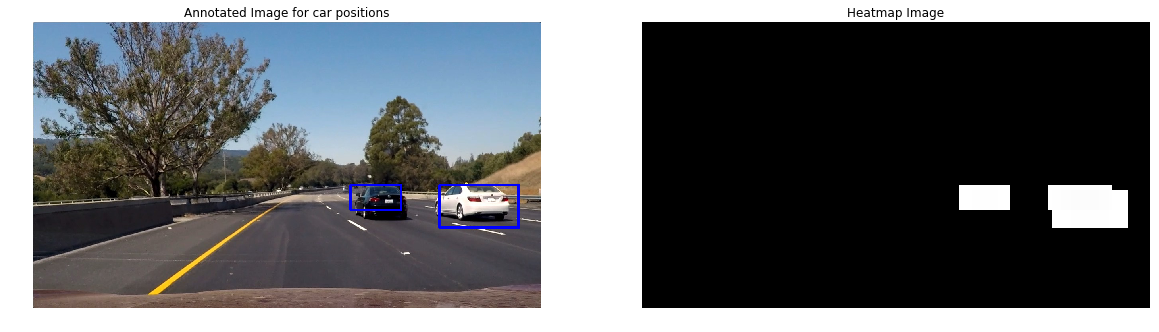

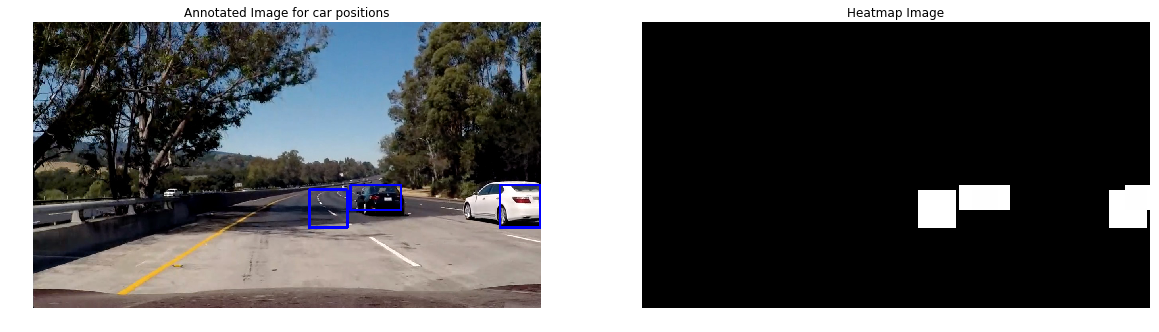

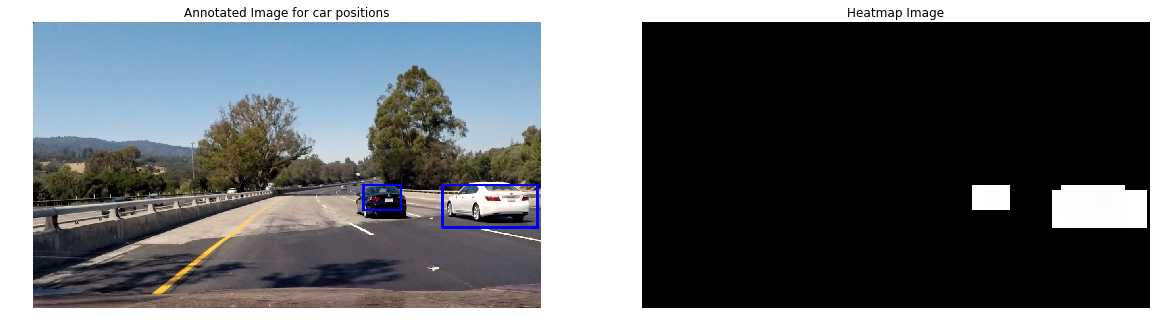

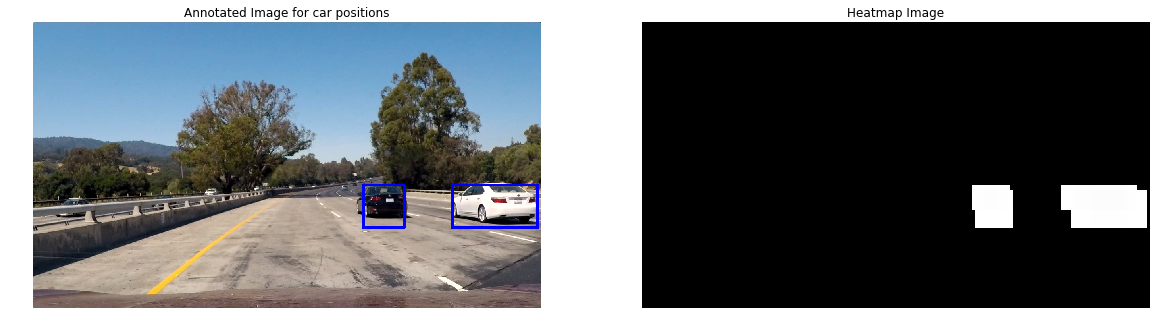

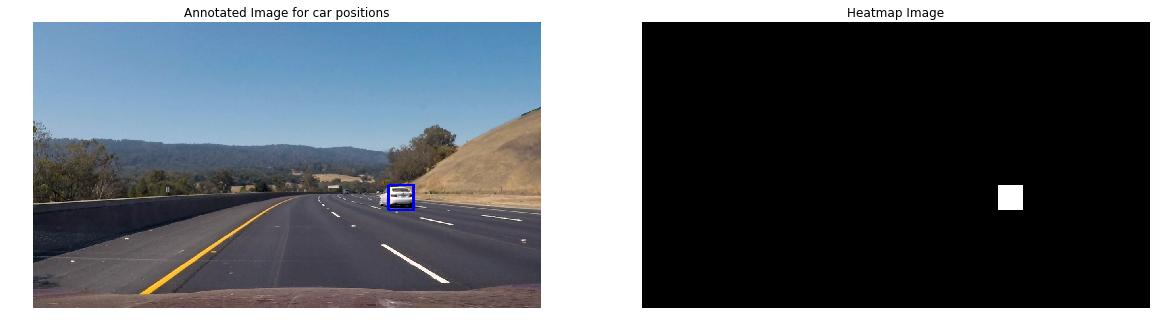

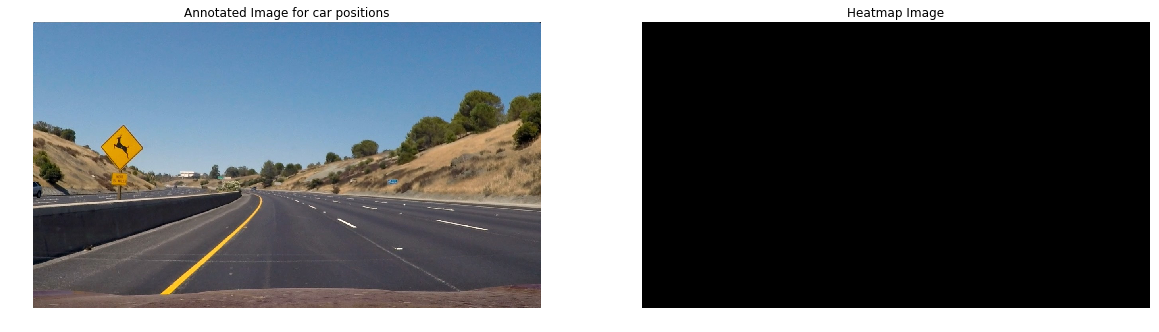

In [40]:
# Make a list of test images
images = glob.glob('./test_images/*.jpg')

# counter for image file naming
i = 0

# plot each image contained in folder location
for image in images:
    # read in test image
    test_image = mpimg.imread(image)
        
    # call function to draw widow boxes onto image fro heatmap
    output_image, heatmap_image = heatmap_window(test_image, svc, X_scaler)
        
    #create the figure
    fig = plt.figure(figsize=(20,10))

    ax1 = plt.subplot(1, 2, 1)
    plt.imshow(output_image)
    plt.axis('off')
    plt.title('Annotated Image for car positions')
    
    ax1 = plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow((heatmap_image * 255).astype(np.uint8), cmap='hot')
    plt.title('Heatmap Image')
    
    i = i+1
    
    # fig save for report - and minimse amout of white space added to saved image
    plt.savefig('./output_images/heatmap_' + str(i) + '.png', bbox_inches='tight')

plt.show()
        
        
        
        

### Video processing function

In [41]:
from moviepy.editor import VideoFileClip
from functools import reduce

# create variable to hold history
history = []

def processImage(img):
    
    global history
    
    # required if search image is jpeg and training data was png
    search_image = img.astype(np.float32)/255
    
    # Extract Slide Window boxes
    #window_boxes = slide_window(search_image, x_start_stop, y_start_stop, xy_window, xy_overlap)
    window_boxes = multi_windows(search_image)
    
    # Find hot Windows
    hot_windows = search_for_cars(search_image, window_boxes, svc, X_scaler)
    
    # create a heatmap from detected windows
    heatmap = add_heat(np.zeros(search_image.shape), hot_windows)
    
    # set length of history to retain windows
    history_length = 5
    
    # set maximum amount of history to retain
    if len(history) >= history_length:
        # if history reaches count, then pop one off oldest data from array
        history = history[1:]
        
    # append heatmap to history array
    history.append(heatmap)
    # sum all history elements and divide by history length
    heat_history = reduce(lambda x, y: x + y, history)/history_length
    
    # set threshold of heatmap to retain
    heatmap = apply_threshold(heat_history, 0.9)
    # create label from heatmap
    labels = label(heatmap)
    
    # draw boxes onto image 
    out_img = draw_labeled_bboxes(np.copy(img), labels)

    # return annotaed image and heatmap image
    return out_img
    

### Video Output - Vehicle Tracking

In [42]:
output_Video = "output_project_video.mp4"
input_Video = "project_video.mp4"

# specify the video to use
clip = VideoFileClip(input_Video) #.subclip(0, 2)
# feed a colour processed image into video_clip
video_clip = clip.fl_image(processImage)
# append video image to video file and print CPU time and wall time
%time video_clip.write_videofile(output_Video, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [08:18<00:00,  2.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 30min 21s, sys: 30.4 s, total: 30min 52s
Wall time: 8min 19s


In [43]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('output_project_video.mp4'))